# Spatial and Urban Data Science

**In this module, we will learn the basics of working with spatial data and conducting spatial network analysis.**

More specifically, we will introduce:

1. Basic spatial data and GIS operations using [geopandas](https://geopandas.org/), which spatializes pandas dataframes. It uses the [shapely](https://shapely.readthedocs.io/en/latest/manual.html) package for geometry.

2. Spatial network modeling and analysis with [OSMnx](https://osmnx.readthedocs.io), which allows you to download, model, analyze, and visualize street networks (and other spatial data) anywhere in the world from [OpenStreetMap](https://www.openstreetmap.org/#map=4/38.01/-95.84), an open source geodatabase that provides freely accessible spatial data worldwide.

3. Urban accessibility analysis using [Pandana](https://udst.github.io/pandana/), which uses contraction hierarchies for imprecise but very fast shortest path calculation.

Relevant readings:  
- Gimond, Intro to GIS and Spatial Analysis, ch. 1, 2, 9. [Direct link](https://mgimond.github.io/Spatial/introGIS.html).
- Kontokosta. 2018. Urban Informatics in the Science and Practice of Planning. Journal of Planning Education and Research. [Direct link](https://journals.sagepub.com/doi/10.1177/0739456X18793716).
- Townsend. 2015. Cities of Data: Examining the New Urban Science. Public Culture. [Direct link](https://read.dukeupress.edu/public-culture/article-abstract/27/2%20(76)/201/73695/Cities-of-Data-Examining-the-New-Urban-Science?redirectedFrom=fulltext).
- Mattern. 2013. Methodolatry and the Art of Measure: The New Wave of Urban Data Science. Places. [Direct link](https://placesjournal.org/article/methodolatry-and-the-art-of-measure/?cn-reloaded=1).
- O'Sullivan. 2014. Spatial Network Analysis. Handbook of Regional Science, edited by Fischer and Nijkamp. [Direct link](https://link.springer.com/referenceworkentry/10.1007%2F978-3-642-23430-9_67)
- Boeing and Arribas-Bel. 2021. GIS and Computational Notebooks. In: The Geographic Information Science & Technology Body of Knowledge, edited by J.P. Wilson. [Direct link](https://gistbok.ucgis.org/bok-topics/gis-and-computational-notebooks)
- Boeing, G. 2017. OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks. Computers, Environment and Urban Systems. [Direct link](https://www.sciencedirect.com/science/article/pii/S0198971516303970)

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx
import numpy as np
import osmnx as ox
import pandana

# configure OSMnx
cache_folder = '../../data/cache2'
ox.config(log_console=True, use_cache=True, cache_folder=cache_folder)

# Working with spatial data

## 1. Quick overview of key concepts

### What is GIS?

GIS stands for geographic information system. GIS software lets you work with spatial data, that is, data associated with locations on the Earth. These locations are represented with coordinates: longitude (x), latitude (y), and often elevation (z). With GIS software you can collect, edit, query, analyze, and visualize spatial data. Examples of GIS software include ArcGIS, QGIS, PostGIS, and GeoPandas. Points, Lines and Polygons are three basic spatial elements of GIS vector data. 

### Some terminology:

- **geoid**: (that's *gee-oid*) the surface of the earth's gravity field, which approximates mean sea level
- **spheroid** or **ellipsoid** (interchangeable terms): a model that smoothly approximates the geoid
- **datum**: based on spheroid but incorporates local variations in the shape of the Earth. Used to describe a point on the Earth's surface, such as in latitude and longitude.
  - WGS84 (World Geodetic Survey 1984 datum) uses the WGS84 spheroid
  - The latitude and longitude coordinates of some point differ slightly based on the datum. GPS uses WGS84.
- **coordinate reference system** (CRS) or spatial reference system (SRS): a series of parameters that [define](http://spatialreference.org/) the coordinate system and spatial extent (aka, domain) of some dataset.
- **geographic coordinate system** (GCS): specifies a datum, spheroid, units of measure (such as meters), and a prime meridian
- **projected coordinate system** or map projection: projects a map of the Earth's 3-D spherical surface onto a flat surface that can be measured in units like meters. Here's a [list of projections](https://en.wikipedia.org/wiki/List_of_map_projections).
- **eastings** and **northings**: the x and y coordinates of a projected map, usually measured in meters
- **false origin**: the 0,0 origin point from which eastings and northings are measured on a map, usually the lower left corner rather than the center
- **PROJ.4**: a library to convert/project spatial data with consistent CRS [parameter names](https://github.com/OSGeo/proj.4/wiki/GenParms)


## 2. Spatial data and GeoPandas

You can use a GIS like ArcGIS or QGIS to open a spatial data file (typically a shapefile, GeoJSON file, or CSV file with lat-long columns). Today we'll introduce the basic concepts of spatial data and GIS operations using geopandas, an open source project to make working with geospatial data in python. We'll focus on common, shared concepts and operations.

### 2a. Loading a shapefile

Where to get census shapefiles? https://www.census.gov/cgi-bin/geo/shapefiles/index.php

The term "shapefile" is a misnomer... a shapefile is actually a folder containing multiple files that contain spatial geometry, attribute data, projection information, etc: https://en.wikipedia.org/wiki/Shapefile

The Census API recently published [censusviz package](https://pypi.org/project/censusviz/) to help map Census data in Python via Census Population Estimate API and the Census Cartographic GeoJSON boundary files

In [2]:
# tell geopandas to read a shapefile with its read_file() function, passing in the shapefile folder
# this produces a GeoDataFrame
# the data I am using here contain all US county polygon
gdf = gpd.read_file('data/cb_2013_us_county_5m/cb_2013_us_county_5m.shp')
gdf.shape

(3234, 10)

In [3]:
# just like regular pandas, see the first 5 rows of the GeoDataFrame
# this is a shapefile of polygon geometries, that is, county boundaries
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,061,00277295,0500000US06061,06061,Placer,06,3643636599,247086378,"POLYGON ((-121.48444 38.75135, -121.46980 38.7..."
1,09,013,00212668,0500000US09013,09013,Tolland,06,1062460624,17686143,"POLYGON ((-72.51333 41.94540, -72.49273 41.947..."
2,18,043,00450350,0500000US18043,18043,Floyd,06,383154033,2644456,"POLYGON ((-86.03282 38.41790, -86.01414 38.419..."
3,21,057,00516875,0500000US21057,21057,Cumberland,06,790416941,14830095,"POLYGON ((-85.60162 36.87220, -85.58053 36.868..."
4,47,069,01639750,0500000US47069,47069,Hardeman,06,1729454851,6823701,"POLYGON ((-89.18394 35.39713, -89.18255 35.432..."


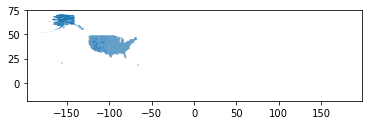

In [5]:
# mapping is as easy as calling the GeoDataFrame's plot method
ax = gdf.plot()

In [5]:
# just like in regular pandas, we can filter and subset the GeoDataFrame
# exclude counties in island states
island = gdf['STATEFP'].isin(['15','69','66','02','72','60', '78'])
gdf_county = gdf[~island]

gdf_county.shape

(3109, 10)

In [7]:
# what is the CRS?
# this derives from the shapefile's .prj file
# always make sure the shapefile you load has prj info so you get a CRS attribute!
gdf_county.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

When we loaded the shapefile, geopandas loaded the CRS from the shapefile itself. But if you are loading a CSV file with lat lon geometry that is not explicitly spatial and it contains no CRS data, remember that you should always define the CRS manually.  

You need to look up an appropriate projection for the spatial extents of your data/map. This is a huge topic in and of itself, so for today we'll just focus on some (over-simplified) rules of thumb:

  1. If you're mapping global data, choose a global projection like [Mercator](https://spatialreference.org/ref/sr-org/16/) or [Robinson](https://spatialreference.org/ref/esri/54030/)
  1. If you're mapping national data, choose a national projection like [epsg:2163](https://spatialreference.org/ref/epsg/2163/) for the US

https://spatialreference.org/ is a good resource. There you can click the "proj4" link on any CRS's page to get a string you can use with geopandas.

Here in this case, I project the my county data to 'epsg:2163', a CRS appropriate for projecting USA data:

In [8]:
# define a CRS appropriate for projecting USA data
usa_crs = 'epsg:2163'

gdf_county_proj = gdf_county.to_crs(usa_crs)

**Be careful**: heed the difference between `gdf.crs` and `gdf.to_crs()`. The first tells you the geodataframe's current CRS. The latter projects the geodataframe to a new CRS.

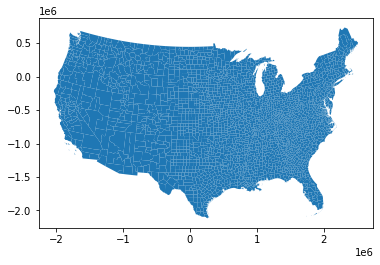

In [9]:
# plot the projected county
ax = gdf_county_proj.plot()

### 2b. Loading a CSV file

Here, we load a csv file with county-level demographic data from ACS, we want to merge this with the county shapefile in order to map those data

In [10]:
# load acs county-level data as a regular pandas dataframe
# this is not spatial data as it has no geometry defined in the dataframe
df = pd.read_csv('data/us_county_acs_data.csv')
df.shape

(3127, 45)

In [11]:
df.head()

,fips,state,year,CountyNameStateAbbreviation,nonmetro,metro,largemetro,smallmetro,RUCC,edu_bacherate,...,perc_femaleemp,raceedu_gap,race_homeowngap,poverty_white,poverty_minority,race_povertygap,z_perc_minor,z_raceedu_gap,z_race_homeowngap,z_race_povertygap
0,13159,GA,2015,"Jasper County, GA",0,1,1,0,1,11.812768,...,0.190613,0.578092,0.098106,1776,1009,0.107386,0.575824,0.530019,0.620171,0.066741
1,41067,OR,2015,"Washington County, OR",0,1,1,0,1,41.899132,...,0.227378,0.646886,0.142895,43178,21683,0.073754,0.354078,0.296808,0.340605,0.365100
2,51177,VA,2015,"Spotsylvania County, VA",0,1,1,0,1,30.371456,...,0.230807,0.563850,0.182424,6020,4376,0.069633,0.553407,0.578300,0.093869,0.401655
3,22087,LA,2015,"St. Bernard Parish, LA",0,1,1,0,1,13.555163,...,0.182090,0.572725,0.245920,5008,3201,0.106974,0.676235,0.548211,-0.302464,0.070396
4,44003,RI,2015,"Kent County, RI",0,1,1,0,1,32.609238,...,0.254689,0.878656,0.183031,12641,1122,0.008429,-0.545715,-0.488886,0.090080,0.944608


In [12]:
df.columns

Index(['fips', 'state', 'year', 'CountyNameStateAbbreviation', 'nonmetro',
       'metro', 'largemetro', 'smallmetro', 'RUCC', 'edu_bacherate',
       'unemprate', 'povertyrate', 'averagefirmsize', 'age25to44', 'age45to64',
       'clusterstrength', 'Name of Area', 'RUCC_code', 'RUCC_des',
       'totculest15', 'totculbirth15', 'totculdeath15', 'ctyname', 'est15',
       'emp15', 'annpayroll15', 'inclu_index', 'Total Population',
       'Population Density sqmile', 'perc_white', 'perc_hisp', 'perc_minor',
       'perc_female', 'Female_Employed', 'foreign_pop', 'perc_femaleemp',
       'raceedu_gap', 'race_homeowngap', 'poverty_white', 'poverty_minority',
       'race_povertygap', 'z_perc_minor', 'z_raceedu_gap', 'z_race_homeowngap',
       'z_race_povertygap'],
      dtype='object')

### 2b. Merge data

In [13]:
# now we have two dataset, one is the county level shapefile, the other is the csv file containing county-level demographic data
# we can perform merge using pandas based on their common field (county code) to combine the two dataset
gdf_county_proj['GEOID'] = gdf_county_proj['GEOID'].astype(int)
gdf_county_proj = gdf_county_proj.set_index('GEOID').sort_values(by='GEOID')

df['fips'] = df['fips'].astype(int)
df = df.set_index('fips').sort_values(by='fips')

df_data = pd.merge(left=df, right=gdf_county_proj, how='inner', left_index=True, right_index=True)

In [14]:
# create a new geopandas geodataframe manually from the pandas dataframe
gdf_data = gpd.GeoDataFrame(df_data)
gdf_data.columns

Index(['state', 'year', 'CountyNameStateAbbreviation', 'nonmetro', 'metro',
       'largemetro', 'smallmetro', 'RUCC', 'edu_bacherate', 'unemprate',
       'povertyrate', 'averagefirmsize', 'age25to44', 'age45to64',
       'clusterstrength', 'Name of Area', 'RUCC_code', 'RUCC_des',
       'totculest15', 'totculbirth15', 'totculdeath15', 'ctyname', 'est15',
       'emp15', 'annpayroll15', 'inclu_index', 'Total Population',
       'Population Density sqmile', 'perc_white', 'perc_hisp', 'perc_minor',
       'perc_female', 'Female_Employed', 'foreign_pop', 'perc_femaleemp',
       'raceedu_gap', 'race_homeowngap', 'poverty_white', 'poverty_minority',
       'race_povertygap', 'z_perc_minor', 'z_raceedu_gap', 'z_race_homeowngap',
       'z_race_povertygap', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID',
       'NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry'],
      dtype='object')

Now we have the geodataframe with county polygon geometry and the demographic data we want to map

## 3. Mapping

(-2259318.989842429,
 2743787.7776512564,
 -2259441.9737315555,
 874818.5571526419)

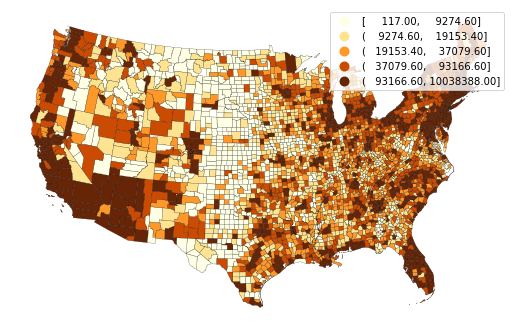

In [15]:
# map using GeoDataFrame plot method with some style configurations
ax = gdf_data.plot(column='Total Population',
                        cmap='YlOrBr', edgecolor='k', lw=0.2, scheme='quantiles',
                        figsize=(9,6), legend=True)

# turn the "axis" off and save to disk
ax.axis('off')
#ax.get_figure().savefig('pop.png', dpi=300, bbox_inches='tight')

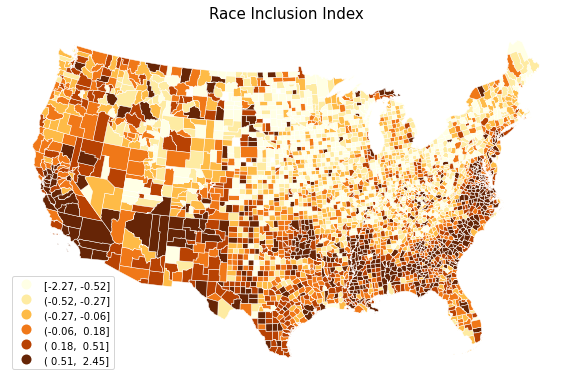

In [16]:
#alternatively, you could use matplotlib for more plotting features
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax = gdf_data.plot(ax=ax, column='inclu_index', scheme='quantiles', k=6, cmap='YlOrBr', edgecolor='white', linewidth=0.5, legend=True, legend_kwds={'loc': 'lower left'})
ax.set_title('Race Inclusion Index', fontsize=15)

ax.set_axis_off()

#fig.savefig('inclusion_index.png', dpi=600)
plt.show()

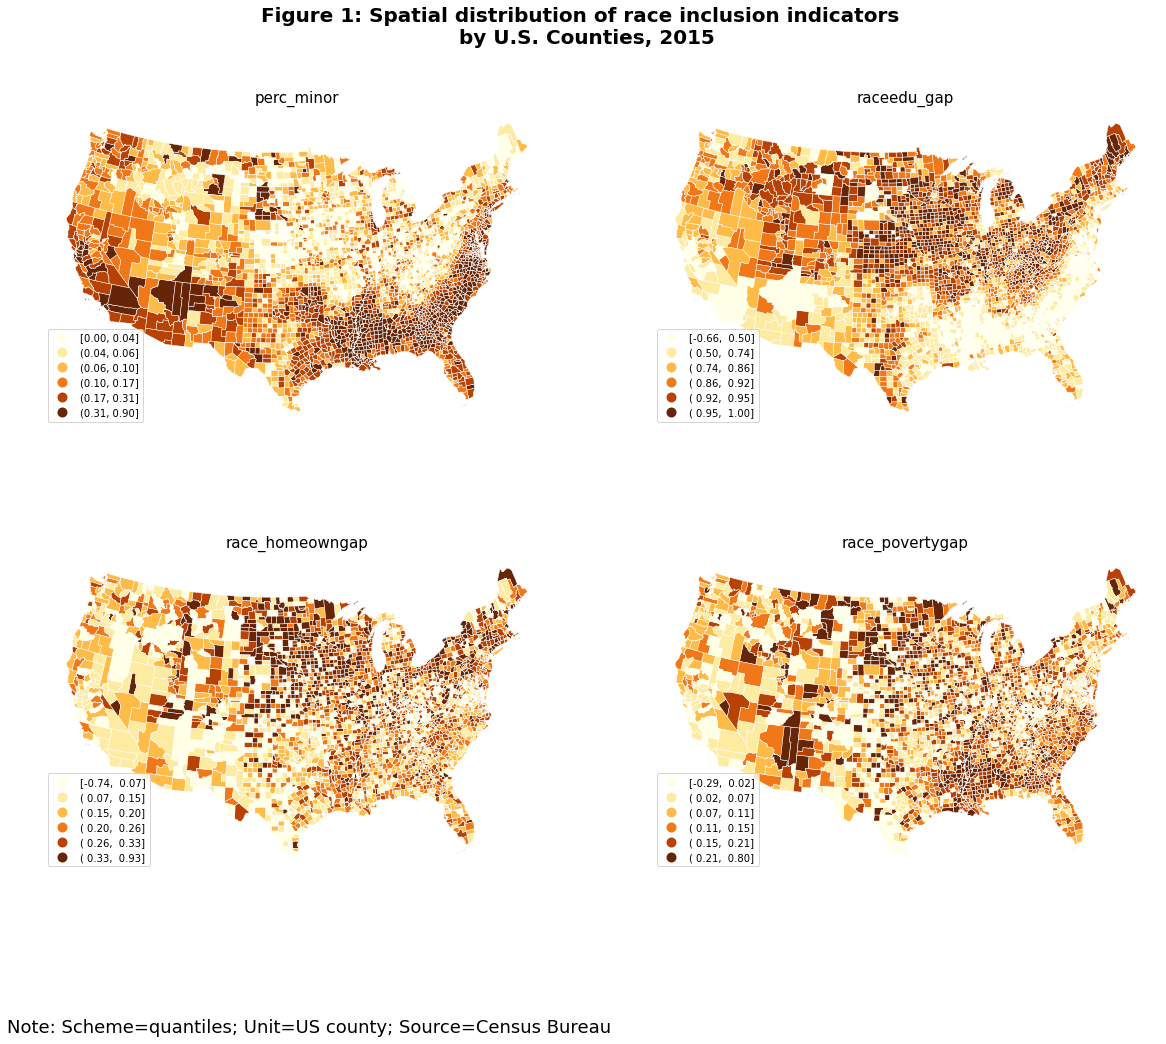

In [17]:
cols = ['perc_minor', 'raceedu_gap', 'race_homeowngap', 'race_povertygap']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

for ax, col in zip(axes.flatten(), cols): 
    ax = gdf_data.plot(ax=ax, column=col, scheme='quantiles', k=6, cmap='YlOrBr', edgecolor='white', linewidth=0.5, legend=True, legend_kwds={'loc': 'lower left'})
    ax.set_title(col, fontsize=15)
    ax.set_axis_off()

# add a title to the figure
fig.suptitle('Figure 1: Spatial distribution of race inclusion indicators \n by U.S. Counties, 2015', y=0.95, fontsize=20, weight='bold')
fig.text(0.1, 0, 'Note: Scheme=quantiles; Unit=US county; Source=Census Bureau', fontsize=18)

#fig.savefig('race_inclusion.png', dpi=200)

plt.show()

**choosing color**  
https://matplotlib.org/users/colormaps.html

Easy rules to (usually) pick a good color map:

- if you have data values rising from some baseline to some maximum, use a perceptually uniform sequential color map.
- if you have data values diverging in both directions from some meaningful center point (e.g., center is zero and values can range positive or negative) then use a diverging color map
- avoid rainbow/jet color maps

# Spatial network analysis

A network is a set of objects (called nodes or vertices) connected to each other by a set of connections (called edges or links). A graph is a mathematical model of a network: usually used synonymously. You can represent a graph as an adjacency matrix to use the tools of linear algebra to analyze it. 

A spatial network is a network that is spatially embedded. That means its nodes and/or edges have locations in space. A spatial network is defined by both its geometry (positions, distances, angles, etc) and its topology (connections and configurations). 

Examples:

  - street networks
  - airline routes
  - rail lines


## 1. Spatial networks and OSMnx

Today we introduce a spatial network analysis tool OSMnx, a Python package that lets you download spatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks. 

OSMnx is built on top of GeoPandas, NetworkX, and matplotlib and interacts with OpenStreetMap’s APIs.

More info:

  - [OSMnx documentation](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)

### 1a. Download and plot street network

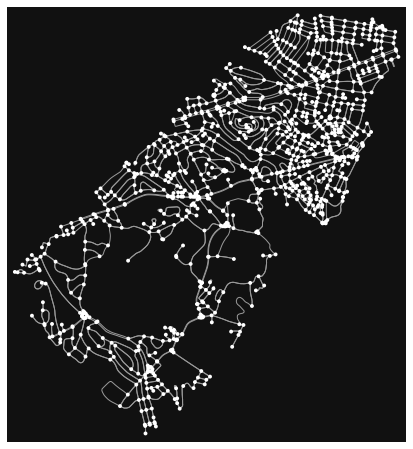

In [10]:
# download/model a street network for some city then visualize it
place = 'Brookline, Massachusetts, USA'

G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Brookline, Massachusetts, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them.

In [11]:
# look at the first 10 nodes: these are OSM IDs
list(G.nodes)[0:10]

[63521894,
 63521982,
 63522256,
 63522262,
 63522312,
 63522443,
 63522491,
 63522501,
 63522517,
 63522569]

In [12]:
# look at the first 10 edges: u, v, key
list(G.edges)[0:10]

[(63521894, 63557763, 0),
 (63521894, 6755494914, 0),
 (63521894, 63572079, 0),
 (63521982, 63563502, 0),
 (63521982, 63530365, 0),
 (63521982, 63532616, 0),
 (63522256, 63581049, 0),
 (63522256, 5972206823, 0),
 (63522262, 63567064, 0),
 (63522262, 63554046, 0)]

In [13]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:

  - undirected NetworkX MultiGraphs
  - NetworkX DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [15]:
# convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,osmid,highway,geometry
63521894,42.337370,-71.121490,63521894,NaN,POINT (-71.12149 42.33737)
63521982,42.333730,-71.127170,63521982,NaN,POINT (-71.12717 42.33373)
63522256,42.337180,-71.118803,63522256,NaN,POINT (-71.11880 42.33718)
63522262,42.303160,-71.151759,63522262,NaN,POINT (-71.15176 42.30316)
63522312,42.345437,-71.127196,63522312,traffic_signals,POINT (-71.12720 42.34544)


In [16]:
gdf_edges.head()

,osmid,lanes,name,highway,maxspeed,width,oneway,length,geometry,junction,ref,tunnel,access,bridge,u,v,key
0,426450173,2,Harvard Street,tertiary,25 mph,24.4,False,36.872,"LINESTRING (-71.12149 42.33737, -71.12146 42.3...",NaN,NaN,NaN,NaN,NaN,63521894,63557763,0
1,8814020,1,Auburn Street,residential,25 mph,12.2,True,117.407,"LINESTRING (-71.12149 42.33737, -71.12225 42.3...",NaN,NaN,NaN,NaN,NaN,63521894,6755494914,0
2,426450173,2,Harvard Street,tertiary,25 mph,24.4,False,94.108,"LINESTRING (-71.12149 42.33737, -71.12146 42.3...",NaN,NaN,NaN,NaN,NaN,63521894,63572079,0
3,8814052,2,Greenough Street,residential,NaN,15.2,False,105.424,"LINESTRING (-71.12717 42.33373, -71.12685 42.3...",NaN,NaN,NaN,NaN,NaN,63521982,63563502,0
4,8814052,2,Greenough Street,residential,NaN,15.2,False,90.941,"LINESTRING (-71.12717 42.33373, -71.12759 42.3...",NaN,NaN,NaN,NaN,NaN,63521982,63530365,0


You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge shapefiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [17]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)
print(len(G2.nodes))
print(len(G2.edges))

1038
2546


## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

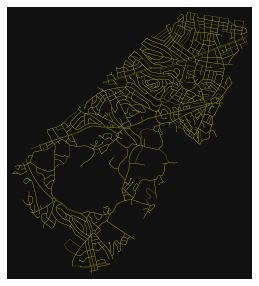

In [18]:
# you can make query an unambiguous dict to help the geocoder find it
place = {'city'   : 'Brookline',
         'state'  : 'Massachusetts',
         'country': 'USA'}

G = ox.graph_from_place(place, network_type='drive', truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(5, 5), node_size=0, edge_color='y', edge_linewidth=0.2)

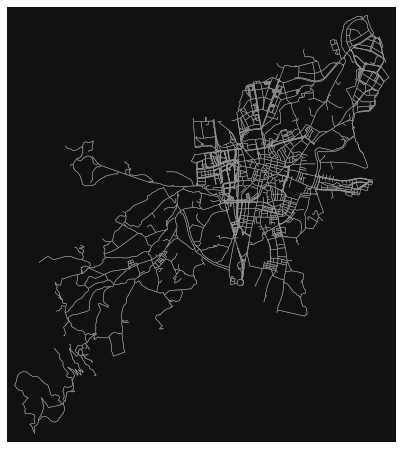

In [19]:
# you can get networks anywhere in the world, try your hometown city!
G = ox.graph_from_place('vic, Spain', network_type='walk')
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

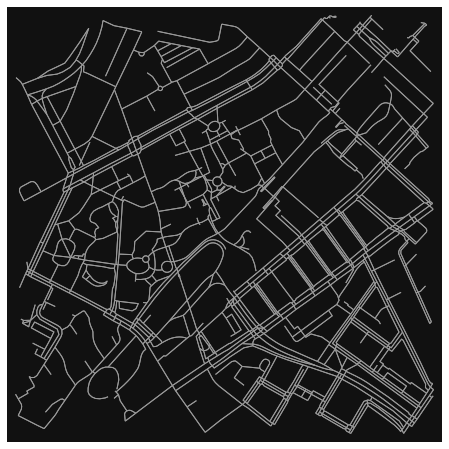

In [27]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
snell_library = (42.338, -71.088) #search in the google map for the lat lon
one_mile = 500 #meters
G = ox.graph_from_point(snell_library, dist=one_mile, network_type='walk')
fig, ax = ox.plot_graph(G, node_size=0)

## Get any geospatial entities' geometries and attributes

Use the `geometries` module to download entities, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame.  


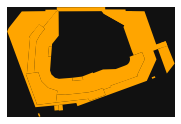

In [20]:
# get all building footprints in some neighborhood
place = 'Fenway park, Boston, Massachusetts'

tags = {'building': True}
gdf = ox.geometries_from_place(place, tags)

fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

In [21]:
# get all parks and bus stops in some neighborhood
place = 'Boston, Massachusetts, USA'

tags = {'leisure': 'park',
        'highway': 'bus_stop'}

gdf = ox.geometries_from_place(place, tags)
gdf.shape

(2533, 144)

For more information about OSM taginfo and key value pairs, see https://wiki.openstreetmap.org/wiki/Tags#Keys_and_values and https://taginfo.openstreetmap.org/

In [22]:
# restaurants near the school
address = '360 Huntington Ave, Boston, MA 02115'
tags = {'amenity' : 'restaurant'}
gdf = ox.geometries_from_address(address, tags=tags, dist=500)
gdf[['name', 'cuisine', 'geometry']].dropna().head()

,name,cuisine,geometry
0,Bangkok Pinto,thai,POINT (-71.08562 42.33657)
1,Ali's Roti,indian,POINT (-71.08550 42.33664)
2,Boston House of Pizza,pizza,POINT (-71.08731 42.34116)
3,Boston Shawarma,international,POINT (-71.08767 42.34100)
4,Ginger Exchange Symphony,asian,POINT (-71.08516 42.34231)


<AxesSubplot:>

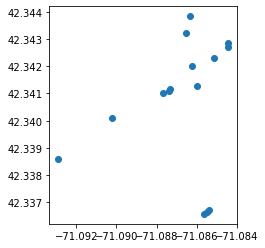

In [23]:
gdf.plot()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  


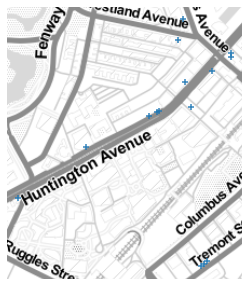

In [24]:
import matplotlib.pyplot as plt 

#add basemap
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
# define the project to work with the basemap
gdf_proj = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(5, 5))
ax = gdf_proj.plot(ax=ax, marker='+', markersize=40, alpha=0.9)
add_basemap(ax, zoom=15, url=ctx.sources.ST_TONER_LITE)
ax.set_axis_off()

## Routing - shortest path analysis

In [25]:
# impute missing edge speeds then calculate edge (free-flow) travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [34]:
# get the nearest network nodes to two lat/lng points
snell_library = (42.338, -71.088)
MFA = (42.339, -71.093)

orig = ox.get_nearest_node(G, snell_library)
dest = ox.get_nearest_node(G, MFA)

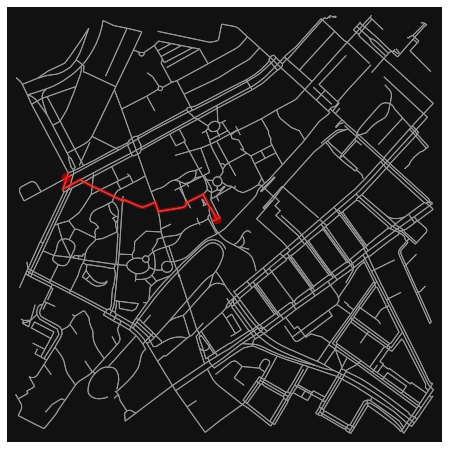

In [35]:
# find the shortest path between these nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [36]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

483.97900000000004

## 2. Urban accessibility and Pandana

Here, we'll analyze food deserts in Brookline using OSMnx and [Pandana](https://udst.github.io/pandana/), a Python library for network analysis that uses contraction hierarchies to calculate super-fast travel accessibility metrics and shortest paths. 

In [26]:
# specify some parameters for the analysis
walk_time = 20  # max walking horizon in minutes
walk_speed = 4.5  # km per hour

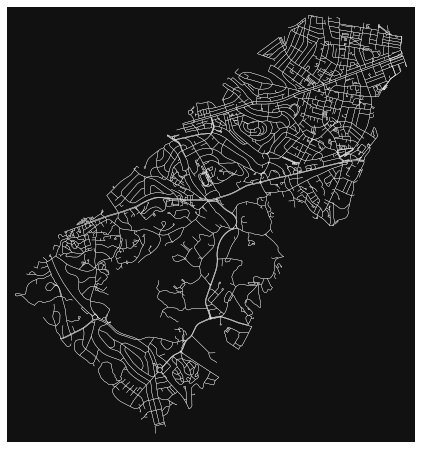

In [27]:
# model the walkable network within our original study site
place = 'Brookline, Massachusetts, USA'

G_walk = ox.graph_from_place(place, network_type='walk')
fig, ax = ox.plot_graph(G_walk, node_size=0, edge_color='w', edge_linewidth=0.3)

In [28]:
# set a uniform walking speed on every edge
for u, v, data in G_walk.edges(data=True):
    data['speed_kph'] = walk_speed
G_walk = ox.add_edge_travel_times(G_walk)

In [29]:
# extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(G_walk, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G_walk, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [30]:
# get all the "fresh food" stores on OSM within the study site
# you could load any amenities DataFrame, but we'll get ours from OSM
tags = {'shop': ['grocery', 'greengrocer', 'supermarket']}

amenities = ox.geometries_from_bbox(north=nodes['y'].max(),
                                    south=nodes['y'].min(),
                                    east=nodes['x'].min(),
                                    west=nodes['x'].max(),
                                    tags=tags)
amenities.shape

(12, 28)

In [31]:
# construct the pandana network model
network = pandana.Network(node_x=nodes['x'],
                          node_y=nodes['y'], 
                          edge_from=edges['u'],
                          edge_to=edges['v'],
                          edge_weights=edges[['travel_time']])

In [32]:
# extract (approximate, unprojected) centroids from the amenities' geometries
centroids = amenities.centroid

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [33]:
# specify a max travel distance for this analysis
# then set the amenities' locations on the network
maxdist = walk_time * 60  # minutes -> seconds, to match travel_time units
network.set_pois(category='grocery',
                 maxdist=maxdist,
                 maxitems=3,
                 x_col=centroids.x, 
                 y_col=centroids.y)

/opt/conda/lib/python3.7/site-packages/pandana/network.py:627: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/opt/conda/lib/python3.7/site-packages/pandana/network.py:635: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [34]:
# calculate travel time to nearest amenity from each node in network
distances = network.nearest_pois(distance=maxdist,
                                 category='grocery',
                                 num_pois=3)
distances.astype(int).head()

,1,2,3
61415012,659,1151,1200
63521894,134,423,972
63521977,949,1200,1200
63521982,844,1050,1084
63522189,0,619,1200


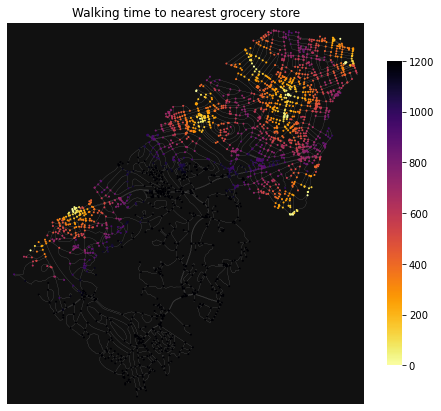

In [35]:
# plot distance to nearest amenity
fig, ax = ox.plot_graph(G_walk, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False)

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'], 
                c=distances[1],
                s=1,
                cmap='inferno_r')

ax.set_title(f'Walking time to nearest grocery store')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

This tells us about the travel time to the nearest amenities, from each node in the network. What if we're instead interested in how many amenities we can reach within our time horizon?

In [36]:
# set a variable on the network, using the amenities' nodes
node_ids = network.get_node_ids(centroids.x, centroids.y)
network.set(node_ids, name='grocery')

# aggregate the variable to all the nodes in the network
# when counting, the decay doesn't matter (but would for summing)
access = network.aggregate(distance=maxdist,
                           type='count',
                           decay='linear',
                           name='grocery')

# let's cap it at 5, assuming no further utility from a larger choice set
access = access.clip(upper=5)
access.describe()

count    2604.000000
mean        2.203149
std         1.663088
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
dtype: float64

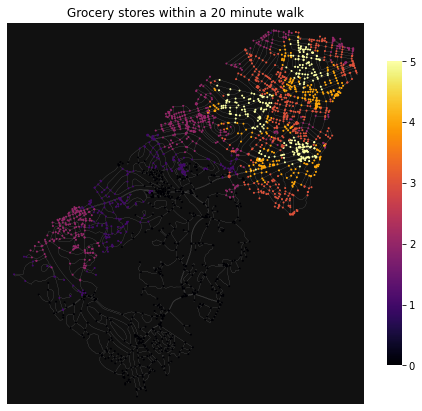

In [38]:
# plot amenity count within your walking horizon
fig, ax = ox.plot_graph(G_walk, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False)

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'], 
                c=access,
                s=1,
                cmap='inferno')

ax.set_title(f'Grocery stores within a {walk_time} minute walk')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')